# Experiment 1. Predicting risk of recurrence and risk of death

## Import libriaries

In [1]:
# Uncomment the following lines if needed

#!pip install openpyxl
#!pip install matplotlib
#!pip install scikit-learn
#!pip install xgboost
#!pip install imblearn
#!pip install lifelines
#!pip install aif360
#!pip install shap

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import utils  # Module with all hand-crafted methods

from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer  # Required to enable IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


## Parameter definition

In [3]:
random_state = 42  # To enable reproducibility

nan_threshold = 600  # Number of NaN values to remove a column

imputer_iter = 10  # Number of iterations for the Iterative Imputer

## Read the dataset and filter columns

In [4]:
# Read dataset
duke = pd.read_excel(
    "../data/DUKE_edit.xlsx",
    skiprows = [0,2],
    usecols = "A:CT"
)

# Columns with no relevant information for our purposes
unneeded_cols = ['Patient ID', 'Days to MRI', 'Manufacturer', 'Manufacturer Model Name',
                 'Scan Options', 'Field Strength (Tesla)', 'Patient Position During MRI',
                 'Contrast Agent', 'Contrast Bolus Volume (mL)', 'TR (Repetition Time)',
                 'TE (Echo Time)', 'Acquisition Matrix', 'Slice Thickness', 'Rows',
                 'Columns', 'Reconstruction Diameter', 'Flip Angle', 'Unnamed: 67',
                 'FOV Computed (Field of View) in cm', 'Definitive Surgery Type',
                 'Image Position of Patient']

# Columns used later as labels in our models and the ones correlated to them
label_cols = ['Recurrence event(s)','Days to local recurrence', 'Days to distant recurrence', 
              'Days to death', 'Days to last local recurrence free assessment',
              'Days to last distant recurrence free assessment', 'Days known alive / to death']

# Store and remove the target columns while dropping the unnecessary ones
labels = duke[label_cols]
data = duke.drop(columns = unneeded_cols + label_cols)

# Print the shape of each DataFrame
print(duke.shape, data.shape, labels.shape)

(922, 98) (922, 70) (922, 7)


## Preprocessing data

We want to apply a classifier to predict recurrence and death risks. Hence, we need clean data, with missing values appropiately treated. First, we deal with $\textit{'No present'}$ and $\textit{'No conclusive'}$ values present in integer rows and remove the columns with more than 600 $NaN$ values out of all 922 instances.

In [5]:
# Print types of values of a int column containing strings
print(data['If Bilateral, Different Rec Status'].value_counts(), end="\n\n")

# Replace all instances of 'NC' and 'NP' with NaN
data.replace('NC', np.nan, inplace=True)
data.replace('NP', np.nan, inplace=True)

# Copy the data before preprocessing to assess baseline
baseline_data = data.copy()

# Compute the number of NaN values
nan_counts = data.isna().sum()

# Identify columns to drop
nan_cols = nan_counts[nan_counts > nan_threshold].index

# Drop the identified columns
data = data.drop(columns=nan_cols)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Convert categorical data into numerical dtypes
for column in data.select_dtypes(include=['object']).columns:
    data[column] = label_encoder.fit_transform(data[column])

If Bilateral, Different Rec Status
NP    623
NC    271
0      26
1       2
Name: count, dtype: int64



The next step is to deal with all $NaN$ values, as some models do not accept them. To do so, we need to treat each column independently and input data in the most harmless way we can.

In [6]:
# Enumerate the columns we want to fill with the mean
imputed_cols = ['Tumor Grade (T)', 'Tumor Grade (N)', 'Tumor Grade (M)', 'Bilateral breast cancer?',
                'Surgery', 'Days to Surgery', 'Neoadjuvant Radiation Therapy', 'Adjuvant Radiation Therapy',
                'Neoadjuvant Chemotherapy', 'Adjuvant Chemotherapy', 'Neoadjuvant Endocrine Therapy Medications',
                'Adjuvant Endocrine Therapy Medications', 'Neoadjuvant Anti-Her2 Neu Therapy',
                'Adjuvant Anti-Her2 Neu Therapy', 'Received Neoadjuvant Therapy']

# Apply the imputer only to the columns we specified
data[imputed_cols] = SimpleImputer(strategy='mean').fit_transform(data[imputed_cols])

# Compute the sum of the three columns of Tumor Grade
grade_sum = data[['Tumor Grade (T)', 'Tumor Grade (N)', 'Tumor Grade (M)']].sum(axis=1)

# Define conditions for Nottingham grade
# Because of the previous imputation, we have to define intervals for each value
conditions = [
    (grade_sum >= 3) & (grade_sum < 5.5),
    (grade_sum >= 5.5) & (grade_sum < 7.5),
    (grade_sum >= 7.5) & (grade_sum <= 9)
]

# Fill values using the previous conditions to assign a value between 1 and 3
data['Nottingham grade'] = np.select(conditions, [1, 2, 3], default=data['Nottingham grade'])

# Enumerate the rest of imputed columns
imputed_cols = ['Staging (Tumor Size)', 'Staging (Nodes)', 'Histologic type']

# Apply the iterative imputer only to the columns we selected
data[imputed_cols] = IterativeImputer(max_iter=imputer_iter, random_state=random_state).fit_transform(data[imputed_cols])

We now create the target columns required for our experiment.

In [7]:
# Replace all instances of 'NP' with NaN
labels.replace('NP', np.nan, inplace=True)

# Define variables for these columns for easier reading
loc = labels['Days to local recurrence']
dis = labels['Days to distant recurrence']

# Define days to recurrence as the minimum between local and distant (not enough cases separately)
labels['Days to recurrence'] = np.where(np.isnan(loc), dis, np.where(np.isnan(dis), loc, np.minimum(loc, dis)))
labels.loc[:, 'Recurrence'] = np.where(labels['Days to recurrence'].notna(), 1, 0)

# Define Dead column to use it later in our experiment
labels.loc[:, 'Dead'] = np.where(labels['Days to death'].notna(), 1, 0)

# Replace NaN values by 0 for later prediction (NaNs not allowed)
labels.fillna(0, inplace=True)

## Compute baseline

Now that we have processed data, we establish a baseline model for both prediction of $\textit{Recurrence}$ and $\textit{Dead}$, which will serve as an indicator of whether our preprocessing was successful or not.

In [8]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Convert categorical data into numerical dtypes
for column in baseline_data.select_dtypes(include=['object']).columns:
    baseline_data[column] = label_encoder.fit_transform(baseline_data[column])

baseline_rec = utils.assess_baseline(baseline_data, labels['Recurrence'], True)
baseline_death = utils.assess_baseline(baseline_data, labels['Dead'], True)

## Recurrence study

#### Predicting risk of recurrence

First, we compare 6 models with the baseline and see which one performs best through usual metrics ($\textbf{MCC}$ stands for $\textit{Matthews Correlation Coefficient}$).

In [10]:
recurrence_summary = pd.concat([baseline_rec, utils.compare_models(data, labels, 'Recurrence')], axis=0, ignore_index=True)

recurrence_summary.head(7)

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,Baseline,0.886486,0.285714,0.111111,0.160000,0.126077
1,Logistic Regression,0.898043,0.450000,0.044444,0.079234,0.108516
2,Decision Tree,0.780981,0.109206,0.166667,0.128107,0.013474
3,Random Forest,0.899130,0.000000,0.000000,0.000000,-0.014577
4,XGBoost,0.896974,0.383333,0.066667,0.105901,0.118496
5,SVM,0.901298,0.000000,0.000000,0.000000,-0.004868
6,K-Nearest Neighbors,0.896951,0.000000,0.000000,0.000000,-0.018676


Next, we perform the same experiment but balancing the dataset using $\textbf{SMOTE}$.

In [11]:
recurrence_smote_summary = pd.concat([baseline_rec, utils.compare_models(data, labels, 'Recurrence', True)], axis=0, ignore_index=True)

recurrence_smote_summary.head(7)

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,Baseline,0.886486,0.285714,0.111111,0.160000,0.126077
1,Logistic Regression,0.677867,0.145325,0.477778,0.222611,0.112163
2,Decision Tree,0.296281,0.103980,0.811111,0.184068,0.036805
3,Random Forest,0.404542,0.115446,0.755556,0.199823,0.076114
4,XGBoost,0.209301,0.103023,0.911111,0.184928,0.029787
5,SVM,0.829677,0.156905,0.155556,0.154191,0.061555
6,K-Nearest Neighbors,0.633349,0.094237,0.322222,0.145500,-0.007134


Finally, we predict the survival time before the event ocurrs (in this case, before the patient suffers from $\textit{Recurrence}$).

Mean Absolute Error (MAE) for instances where event occurred: 376.49811761501195
Root Mean Squared Error (RMSE) for instances where event occurred: 476.99398534218477


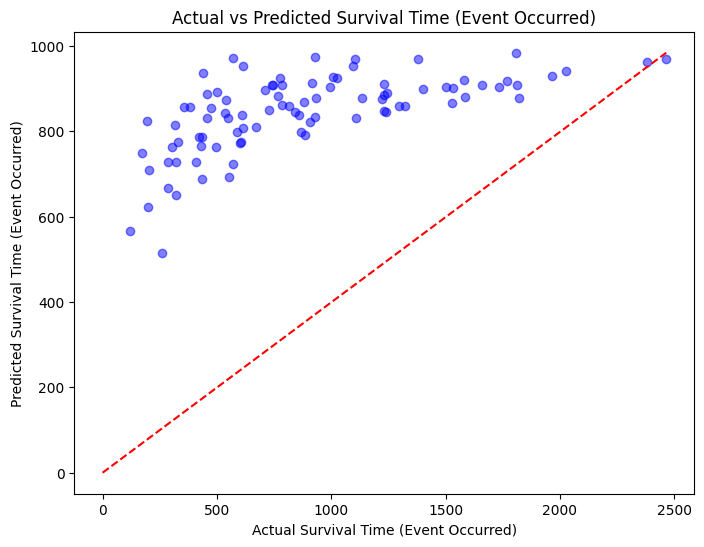

In [12]:
utils.predict_lifetime(data, labels, 'Days to recurrence', 'Recurrence')

#### Interpretability and Fairness assessment

We plot the SHAP values to rank features by relevance in our predictions. In the case of non-tree based models (such as $\textit{Logistic Regression}$), this computation is quite expensive. Hence, we only perform the plot for the best model we have.

Plotting SHAP values for predicting Recurrence using XGBoost...


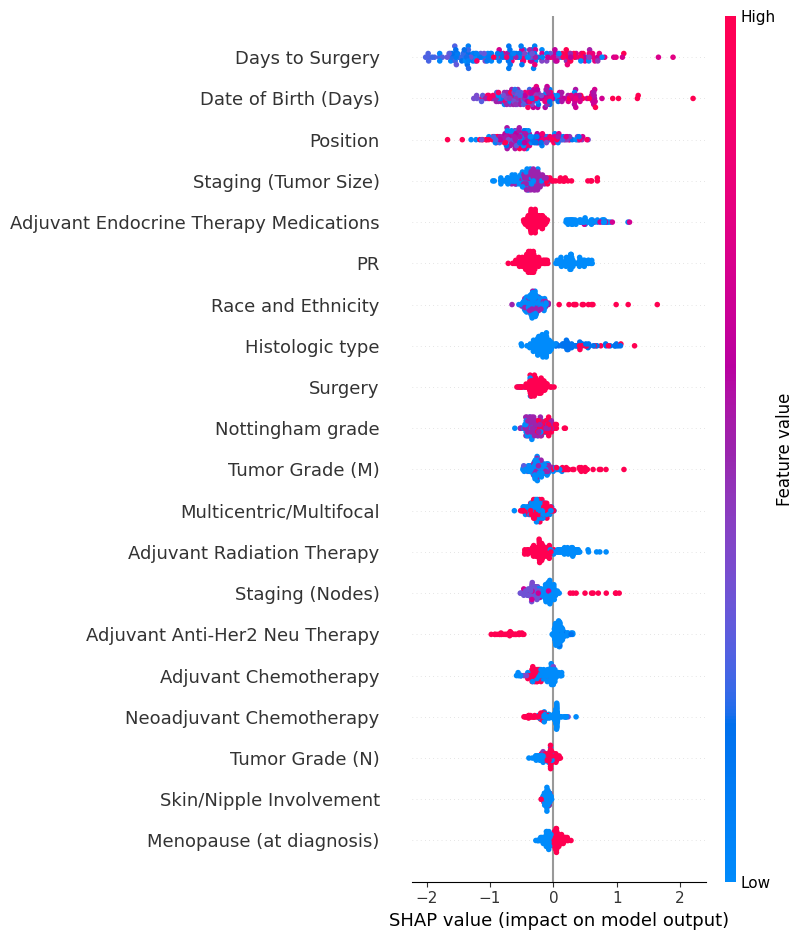

In [13]:
utils.plot_shap_values('XGBoost', data, labels, 'Recurrence')

After choosing the protected attributes of our dataset, we perform a fairness study of them for the chosen model.

In the following DataFrame:
- $\textbf{BP}$ stands by $\textit{Before Prediction}$
- $\textbf{AP}$ stands by $\textit{After Prediction}$
- $\textbf{SPD}$ stands by $\textit{Statistical Parity Difference}$
- $\textbf{DI}$ stands by $\textit{Disparate Impact}$
- $\textbf{EOD}$ stands by $\textit{Equal Opportunity Difference}$

In [21]:
# Define protected attributes and privileged/unprivileged subgroups
protected = ['Race and Ethnicity', 'Mol Subtype', 'Bilateral breast cancer?']
priv_groups = [[{'Race and Ethnicity': 1}], [{'Mol Subtype': 0}], [{'Bilateral breast cancer?': 0}]]
unpriv_groups = [[{'Race and Ethnicity': 0}] + [{'Race and Ethnicity': value} for value in range(2, 9)]]
unpriv_groups.append([{'Mol Subtype': value} for value in range(1, 4)])
unpriv_groups.append([{'Bilateral breast cancer?': 0.043011}, {'Bilateral breast cancer?': 1}])

In [22]:
utils.fairness_study('XGBoost', data, labels, 'Recurrence', protected, priv_groups, unpriv_groups)

,Protected Attribute,SPD (BP),DI (BP),SPD (AP),DI (AP),EOD
0,Race and Ethnicity,0.049892,1.601476,0.049445,4.065574,0.333333
1,Mol Subtype,0.047768,1.592125,0.089552,inf,0.142857
2,Bilateral breast cancer?,0.014045,1.150862,-0.025000,0.000000,-0.090909


## Death study

We proceed in the same way as previously done for $\textit{Recurrence}$.

#### Predicting risk of death

In [16]:
death_summary = pd.concat([baseline_death, utils.compare_models(data, labels, 'Dead')], axis=0, ignore_index=True)

death_summary.head(7)

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,Baseline,0.935135,0.500000,0.083333,0.142857,0.184702
1,Logistic Regression,0.931686,0.557143,0.146154,0.218571,0.245635
2,Decision Tree,0.841663,0.178288,0.241026,0.188791,0.120214
3,Random Forest,0.936022,0.600000,0.082051,0.143150,0.207418
4,XGBoost,0.923008,0.150000,0.032051,0.051667,0.042763
5,SVM,0.932761,0.000000,0.000000,0.000000,0.000000
6,K-Nearest Neighbors,0.936028,0.633333,0.098718,0.167912,0.229167


In [17]:
death_smote_summary = pd.concat([baseline_death, utils.compare_models(data, labels, 'Dead', balance=True)], axis=0, ignore_index=True)

death_smote_summary.head(7)

,Model,Accuracy,Precision,Recall,F1-Score,MCC
0,Baseline,0.935135,0.500000,0.083333,0.142857,0.184702
1,Logistic Regression,0.767885,0.162888,0.596154,0.255627,0.218659
2,Decision Tree,0.417456,0.094381,0.726923,0.162948,0.060803
3,Random Forest,0.613860,0.113683,0.662821,0.188853,0.145299
4,XGBoost,0.278754,0.078735,0.887179,0.143888,0.083143
5,SVM,0.899142,0.254048,0.238462,0.239389,0.189707
6,K-Nearest Neighbors,0.770065,0.160347,0.562821,0.248995,0.205714


Mean Absolute Error (MAE) for instances where event occurred: 314.32971612312855
Root Mean Squared Error (RMSE) for instances where event occurred: 401.92592867504453


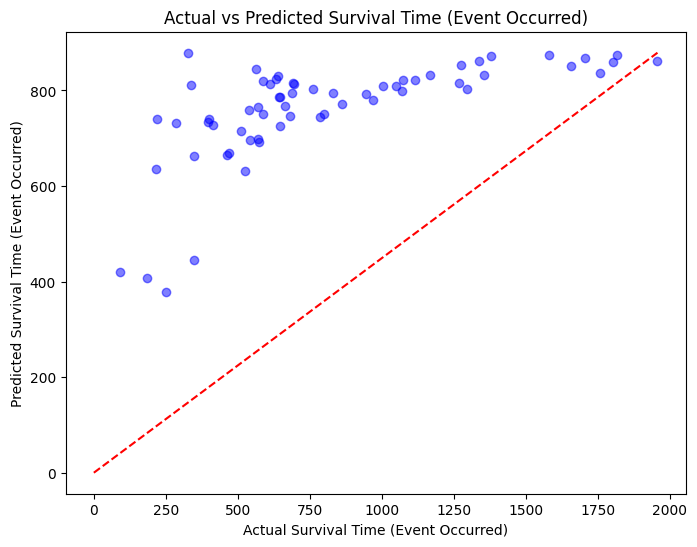

In [18]:
utils.predict_lifetime(data, labels, 'Days to death', 'Dead')

#### Interpretability and Fairness assessment

  0%|          | 0/185 [00:00<?, ?it/s]

Plotting SHAP values for predicting Dead using Logistic Regression...


<Figure size 1200x800 with 0 Axes>

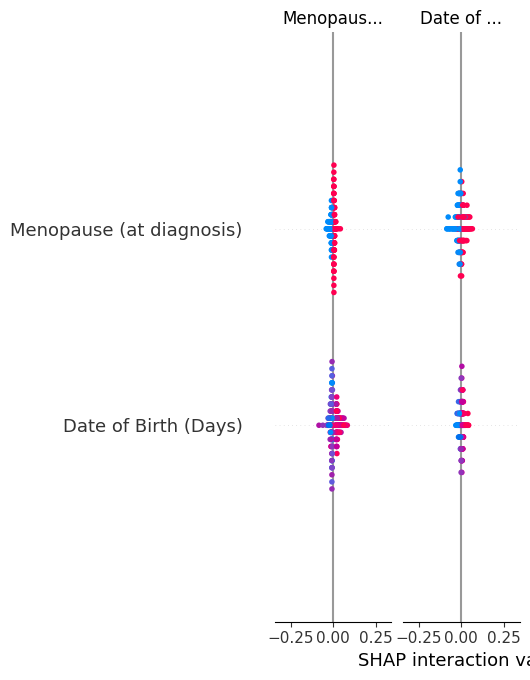

In [19]:
utils.plot_shap_values('Logistic Regression', data, labels, 'Dead', samples=20)

In [24]:
utils.fairness_study('Logistic Regression', data, labels, 'Dead', protected, priv_groups, unpriv_groups)

,Protected Attribute,SPD (BP),DI (BP),SPD (AP),DI (AP),EOD
0,Race and Ethnicity,0.040641,1.734932,0.0,NaN,0.0
1,Mol Subtype,0.052178,2.070547,0.0,NaN,0.0
2,Bilateral breast cancer?,-0.020465,0.635714,0.0,NaN,NaN
